## General Workflow


#### 1. Dataset Loading:
The CIFAR-10 dataset is loaded using the `datasets` library. It is split into training and testing sets.

#### 2. Random Patch Extraction:
Random patches of size 6x6 are extracted from the training images. These patches are used to learn visual features.

#### 3. PCA Whitening:
The extracted patches are normalized and whitened using PCA to reduce redundancy and improve feature representation.

#### 4. K-Means Clustering:
K-Means clustering is applied to the whitened patches to learn a set of centroids. These centroids represent the learned features.

#### 5. Feature Encoding:
Each image is encoded by extracting overlapping patches, whitening them, and computing their activations using the learned centroids. Spatial pooling is applied to generate a fixed-length feature vector for each image.

#### 6. Dataset Encoding:
The entire training and testing datasets are encoded into feature vectors using the learned PCA model and centroids.

#### 7. Feature Standardization:
The encoded features are standardized using `StandardScaler` to ensure they have zero mean and unit variance.

#### 8. Model Training:
A linear classifier (SGD with hinge loss) is trained on the standardized training features to classify the CIFAR-10 images.

#### 9. Model Evaluation:
The trained model is evaluated on the test set. Metrics such as accuracy, confusion matrix, and per-class performance are computed.

#### 10. Visualization:
Various visualizations are generated, including random patches, PCA-whitened patches, and confusion matrices.

#### 11. Subsampling for Faster Training:
To speed up training, a subset of the training data is sampled, ensuring an equal number of samples per class.

#### 12. Saving and Loading:
Intermediate results (e.g., patches, PCA model, centroids, encoded features) are saved to disk for reuse and faster experimentation.




# The notebook is divided into two parts: K=1600 and K=4000
# For testing, please look up where are the np.load(...) and joblib.load(...) in the corresponding blocks and run them. After that, all necessary files: X_train, X_train_std..., and the trained model itself are imported. 

In [1]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from PIL import Image
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import joblib
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support


/Users/ghukasyannarek/Desktop/ML/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
ds = load_dataset("uoft-cs/cifar10")
train_data = ds['train']
test_data = ds['test']

In [2]:
def extract_random_patches(dataset, patch_size=6, num_patches=400000):
    """
    Extract random patches from a dataset of images.

    Parameters:
    dataset (Dataset): The dataset containing images from which patches will be extracted.
    patch_size (int): The size of the square patch to extract. Default is 6.
    num_patches (int): The total number of patches to extract. Default is 400000.

    Returns:
    np.ndarray: A numpy array containing the extracted patches with shape 
                (num_patches, patch_size, patch_size, channels).
    """
    patches = []
    img_count = len(dataset)
    for _ in tqdm(range(num_patches)):
        img_index = np.random.randint(0, img_count)
        img = np.array(dataset[img_index]['img'])
        height, width = img.shape[:2]
        x = np.random.randint(0, height - patch_size + 1)
        y = np.random.randint(0, width - patch_size + 1)

        random_patch = img[x:x+patch_size, y:y+patch_size, :]
        patches.append(random_patch)

    return np.array(patches)

def normalize_and_whiten_with_pca(patches, epsilon=1e-5):
    """
    Normalize and whiten patches using PCA.

    Parameters:
    patches (np.ndarray): A numpy array of shape (num_patches, patch_size, patch_size, channels) 
                          containing the extracted patches.
    epsilon (float): A small constant added to the denominator for numerical stability. Default is 1e-5.

    Returns:
    tuple: A tuple containing:
        - whitened (np.ndarray): The PCA-whitened patches with reduced dimensionality.
        - pca (PCA): The trained PCA model used for whitening.
    """
    patches = patches.astype(np.float32)
    num_patches, h, w, c = patches.shape
    flattened = patches.reshape(num_patches, -1)
    flattened -= np.mean(flattened, axis=1, keepdims=True)
    flattened /= (np.std(flattened, axis=1, keepdims=True) + epsilon)

    flattened -= np.mean(flattened, axis=0, keepdims=True)

    pca = PCA(whiten=True, n_components=0.99)
    whitened = pca.fit_transform(flattened)

    return whitened, pca


def learn_kmeans_centroids(whitened_patches, K=1600, batch_size=1000, seed=888):
    """
    Learn K-means centroids from whitened patches.

    Parameters:
    whitened_patches (np.ndarray): A numpy array of shape (num_patches, num_features) containing 
                                   the PCA-whitened patches.
    K (int): The number of clusters (centroids) to learn. Default is 1600.
    batch_size (int): The size of the mini-batches used in the K-means algorithm. Default is 1000.
    seed (int): The random seed for reproducibility. Default is 888.

    Returns:
    np.ndarray: A numpy array of shape (K, num_features) containing the learned centroids.
    """
    kmeans = MiniBatchKMeans(n_clusters=K, batch_size=batch_size, random_state=seed, verbose=1)
    kmeans.fit(whitened_patches)
    return kmeans.cluster_centers_

def triangle_activation(patches, centroids):
    """
    Compute the triangle activation for patches based on centroids.

    Parameters:
    patches (np.ndarray): A numpy array of shape (num_patches, num_features) containing the input patches.
    centroids (np.ndarray): A numpy array of shape (K, num_features) containing the learned centroids.

    Returns:
    np.ndarray: A numpy array of shape (num_patches, K) containing the triangle activation values.
    """
    distances = np.linalg.norm(patches[:, None, :] - centroids[None, :,:], axis=2)
    mean_distance = np.mean(distances, axis=1, keepdims=True)
    activations = np.maximum(0, mean_distance - distances)
    return activations

def extract_overlapping_patches(img, patch_size, stride=1):
    """
    Extract overlapping patches from an image.

    Parameters:
    img (np.ndarray): The input image of shape (height, width, channels).
    patch_size (int): The size of the square patch to extract.
    stride (int): The step size for moving the patch extraction window. Default is 1.

    Returns:
    tuple: A tuple containing:
        - patches (np.ndarray): A numpy array of shape (num_patches, patch_size * patch_size * channels) 
                                containing the flattened overlapping patches.
        - positions (np.ndarray): A numpy array of shape (num_patches, 2) containing the (row, col) 
                                   positions of the top-left corner of each patch.
    """
    h, w, c = img.shape
    patches = []
    positions = []

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = img[i:i + patch_size, j:j + patch_size, :]
            patches.append(patch.flatten())
            positions.append((i, j))
    
    return np.array(patches), np.array(positions)    

def spatial_pooling(encoded_patches, positions, grid_size=3, image_size=32):
    """
    Perform spatial pooling on encoded patches to generate a fixed-length feature vector.

    Parameters:
    encoded_patches (np.ndarray): A numpy array of shape (num_patches, K) containing the encoded patches.
    positions (np.ndarray): A numpy array of shape (num_patches, 2) containing the (row, col) positions 
                            of the top-left corner of each patch.
    grid_size (int): The number of cells along each dimension of the spatial grid. Default is 3.
    image_size (int): The size of the input image (assumed to be square). Default is 32.

    Returns:
    np.ndarray: A numpy array of shape (grid_size * grid_size * K,) containing the pooled feature vector.
    """
    K = encoded_patches.shape[1]
    pooled_features = np.zeros((grid_size * grid_size, K), dtype=np.float32)
    cell_size = image_size // grid_size

    for idx, (row, col) in enumerate(positions):
        row_cell = min(row // cell_size, grid_size - 1)
        col_cell = min(col // cell_size, grid_size - 1)
        cell_index = row_cell * grid_size + col_cell
        pooled_features[cell_index] += encoded_patches[idx]

    return pooled_features.flatten()

def encode_image(img, patch_size, pca, centroids):
    """
    Encode an image into a fixed-length feature vector using patch extraction, PCA whitening, 
    triangle activation, and spatial pooling.

    Parameters:
    img (np.ndarray): The input image of shape (height, width, channels).
    patch_size (int): The size of the square patch to extract.
    pca (PCA): The trained PCA model used for whitening.
    centroids (np.ndarray): A numpy array of shape (K, num_features) containing the learned centroids.

    Returns:
    np.ndarray: A numpy array of shape (grid_size * grid_size * K,) containing the encoded feature vector.
    """
    patches, positions = extract_overlapping_patches(img, patch_size=patch_size)
    patches = patches.astype(np.float32)
    patches -= np.mean(patches, axis=1, keepdims=True)
    patches /= (np.std(patches, axis=1, keepdims=True) + 1e-5)
    whitened = pca.transform(patches)
    encoded = triangle_activation(whitened, centroids)
    features = spatial_pooling(encoded, positions, grid_size=3, image_size=32)
    return features

def encode_dataset(dataset, patch_size, pca, centroids):
    """
    Encode an entire dataset of images into feature vectors.

    Parameters:
    dataset (Dataset): The dataset containing images and labels.
    patch_size (int): The size of the square patch to extract.
    pca (PCA): The trained PCA model used for whitening.
    centroids (np.ndarray): A numpy array of shape (K, num_features) containing the learned centroids.

    Returns:
    tuple: A tuple containing:
        - features (np.ndarray): A numpy array of shape (num_samples, grid_size * grid_size * K) 
                                 containing the encoded feature vectors for the dataset.
        - labels (np.ndarray): A numpy array of shape (num_samples,) containing the labels for the dataset.
    """
    features = []
    labels = []

    for example in tqdm(dataset):
        img = np.array(example['img'])
        label = example['label']
        feat = encode_image(img, patch_size, pca, centroids)
        features.append(feat)
        labels.append(label)

    return np.array(features), np.array(labels)

# The below is done using K = 1600

In [ ]:
patches = extract_random_patches(train_data, patch_size=6, num_patches=400000)

whitened_patches, pca = normalize_and_whiten_with_pca(patches)

centroids = learn_kmeans_centroids(whitened_patches, K=1600)

X_train, y_train = encode_dataset(train_data, patch_size=6, pca=pca, centroids=centroids)
X_test, y_test = encode_dataset(test_data, patch_size=6, pca=pca, centroids=centroids)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

  0%|          | 0/400000 [00:00<?, ?it/s]100%|██████████| 400000/400000 [00:39<00:00, 10193.28it/s]


Init 1/1 with method k-means++
Inertia for init 1/1: 372076.0
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 1/40000: mean batch inertia: 31.71494921875
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 2/40000: mean batch inertia: 31.9117578125, ewa inertia: 31.9117578125
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 3/40000: mean batch inertia: 32.452814453125, ewa inertia: 31.914463088939932
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 4/40000: mean batch inertia: 31.0066015625, ewa inertia: 31.90992379265597
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 5/40000: mean batch inertia: 31.18836328125, ewa inertia: 31.906315999118423
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 6/40000: mean batch inertia: 30.792515625, ewa inertia: 31.9007470111703
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 7/40000: mean batch inertia: 29.629953125, ewa inertia: 31

100%|██████████| 10000/10000 [35:14<00:00,  4.73it/s]


In [ ]:
np.save("patches.npy", patches) 

np.save("whitened_patches.npy", whitened_patches)
joblib.dump(pca, "pca_model.pkl")                  

np.save("centroids.npy", centroids)                 

np.save("X_train.npy", X_train)                     
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

scaler = StandardScaler()
X_train = np.load("X_train.npy")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
np.save("X_test_std.npy", X_test_std)
np.save("X_train_std.npy", X_train_std)
joblib.dump(scaler, "scaler.pkl")                 

#### After running everything, I have saved all the variables for future calls.

## So, run the code block below to get the necessary data. The trained model is two blocks below for importing.

In [3]:
X_train = np.load("K_1600/X_train.npy")
X_test = np.load("K_1600/X_test.npy")
y_train = np.load("K_1600/y_train.npy")
y_test = np.load("K_1600/y_test.npy")
patches = np.load("K_1600/patches.npy")
pca_model = joblib.load("K_1600/pca_model.pkl")
whitened_patches = np.load("K_1600/whitened_patches.npy")
centroids = np.load("K_1600/centroids.npy")
scaler = joblib.load("K_1600/scaler.pkl")
X_test_std = np.load("K_1600/X_test_std.npy")
X_train_std = np.load("K_1600/X_train_std.npy")


In [19]:
alpha = 1 / (400 * len(X_train_std))

clf = SGDClassifier(
    loss="hinge", 
    penalty="l2", 
    alpha=alpha,
    max_iter=1000,
    tol=1e-3,
    random_state=888,
    verbose=1,
    n_jobs=-1
)
clf.fit(X_train_std, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1

-- Epoch 1
Norm: 176039.47, NNZs: 14400, Bias: -444178.542302, T: 50000, Avg. loss: 63567.068057
Total training time: 1.47 seconds.
-- Epoch 2
Norm: 183823.36, NNZs: 14400, Bias: -435602.751453, T: 50000, Avg. loss: 52142.282751
Total training time: 1.49 seconds.
-- Epoch 2
Norm: 168789.22, NNZs: 14400, Bias: -440032.113010, T: 50000, Avg. loss: 52058.039470
Total training time: 1.49 seconds.
-- Epoch 2
Norm: 186353.30, NNZs: 14400, Bias: -443514.642236, T: 50000, Avg. loss: 64033.561007
Total training time: 1.53 seconds.
-- Epoch 2
Norm: 193161.92, NNZs: 14400, Bias: -451264.019624, T: 50000, Avg. loss: 70796.023660
Total training time: 1.53 seconds.
-- Epoch 2
Norm: 189596.41, NNZs: 14400, Bias: -443482.080823, T: 50000, Avg. loss: 62726.123127
Total training time: 1.55 seconds.
-- Epoch 2
Norm: 180300.66, NNZs: 14400, Bias: -434791.338000, T: 50000, Avg. loss: 53290.446853
Total training time: 1.55 seconds.

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  6.1min remaining:  4.0min


Norm: 115655.53, NNZs: 14400, Bias: -58249.163337, T: 14650000, Avg. loss: 271.629244
Total training time: 363.53 seconds.
-- Epoch 294
Norm: 184446.81, NNZs: 14400, Bias: -323118.686771, T: 6200000, Avg. loss: 648.065774
Total training time: 124.73 seconds.
-- Epoch 125
Norm: 162615.09, NNZs: 14400, Bias: -204684.020234, T: 15100000, Avg. loss: 332.631357
Total training time: 365.75 seconds.
-- Epoch 303
Norm: 137215.08, NNZs: 14400, Bias: -126102.221908, T: 14950000, Avg. loss: 328.859968
Total training time: 365.88 seconds.
-- Epoch 300
Norm: 115471.16, NNZs: 14400, Bias: -58054.176628, T: 14700000, Avg. loss: 261.040706
Total training time: 366.34 seconds.
-- Epoch 295
Norm: 183925.98, NNZs: 14400, Bias: -322361.615582, T: 6250000, Avg. loss: 647.996251
Total training time: 127.12 seconds.
-- Epoch 126
Norm: 162443.44, NNZs: 14400, Bias: -204402.653172, T: 15150000, Avg. loss: 332.870232
Total training time: 367.24 seconds.
-- Epoch 304
Norm: 137029.11, NNZs: 14400, Bias: -125833.7

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.4min finished


SGDClassifier(alpha=5e-08, n_jobs=-1, random_state=888, verbose=1)

## Run the cell below to also import the trained model

In [ ]:
clf = joblib.load("K_1600/sgd_svm_model_300_iter.pkl")

In [5]:
y_pred = clf.predict(X_test_std)
acc = accuracy_score(y_test, y_pred)
print(f"SGD SVM Test Accuracy: {acc * 100:.2f}%")

SGD SVM Test Accuracy: 71.93%


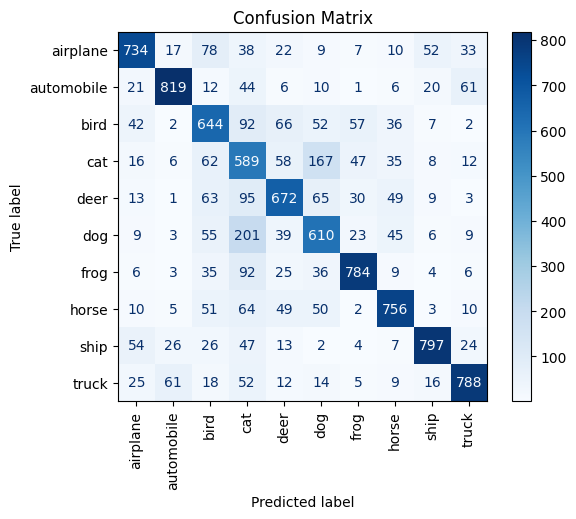

In [6]:
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=cifar10_labels,
    cmap="Blues",
    xticks_rotation=90
)
plt.title("Confusion Matrix")
plt.show()

In [7]:
train_acc = accuracy_score(y_train, clf.predict(X_train_std))
test_acc = accuracy_score(y_test, clf.predict(X_test_std))

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Train Accuracy: 94.10%
Test Accuracy: 71.93%


In [8]:
true_epochs = clf.t_ / X_train_std.shape[0]
print(f"True number of epochs run: {true_epochs:.2f}")

True number of epochs run: 300.00


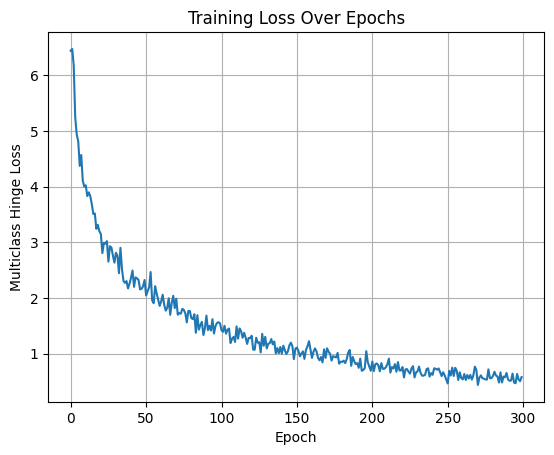

In [ ]:
train_losses = []

for epoch in range(300):
    clf.partial_fit(X_train_std, y_train, classes=np.unique(y_train))
    
    scores = clf.decision_function(X_train_std)  
    
    correct_class_scores = scores[np.arange(len(scores)), y_train]  

    margins = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + 1)  
    margins[np.arange(len(scores)), y_train] = 0 
    
    loss = np.mean(np.sum(margins, axis=1))
    train_losses.append(loss)

plt.plot(train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Multiclass Hinge Loss")
plt.grid(True)
plt.show()

In [9]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

Classification Report:
              precision    recall  f1-score   support

           0      0.789     0.734     0.761      1000
           1      0.869     0.819     0.843      1000
           2      0.617     0.644     0.630      1000
           3      0.448     0.589     0.509      1000
           4      0.699     0.672     0.685      1000
           5      0.601     0.610     0.605      1000
           6      0.817     0.784     0.800      1000
           7      0.786     0.756     0.771      1000
           8      0.864     0.797     0.829      1000
           9      0.831     0.788     0.809      1000

    accuracy                          0.719     10000
   macro avg      0.732     0.719     0.724     10000
weighted avg      0.732     0.719     0.724     10000



In [10]:
classes = np.unique(y_test)
per_class_acc = [(y_test[y_test == cls] == y_pred[y_test == cls]).mean() for cls in classes]

for label, acc in zip(cifar10_labels, per_class_acc):
    print(f"{label:10}: Accuracy = {acc * 100:.2f}%")

print("\nSorted descending per-class accuracy:")
label_acc_pairs = list(zip(cifar10_labels, per_class_acc))
sorted_pairs = sorted(label_acc_pairs, key=lambda x: x[1], reverse=True)
for label, acc in sorted_pairs:
    print(f"{label:10}: Accuracy = {acc * 100:.2f}%")

airplane  : Accuracy = 73.40%
automobile: Accuracy = 81.90%
bird      : Accuracy = 64.40%
cat       : Accuracy = 58.90%
deer      : Accuracy = 67.20%
dog       : Accuracy = 61.00%
frog      : Accuracy = 78.40%
horse     : Accuracy = 75.60%
ship      : Accuracy = 79.70%
truck     : Accuracy = 78.80%

Sorted descending per-class accuracy:
automobile: Accuracy = 81.90%
ship      : Accuracy = 79.70%
truck     : Accuracy = 78.80%
frog      : Accuracy = 78.40%
horse     : Accuracy = 75.60%
airplane  : Accuracy = 73.40%
deer      : Accuracy = 67.20%
bird      : Accuracy = 64.40%
dog       : Accuracy = 61.00%
cat       : Accuracy = 58.90%


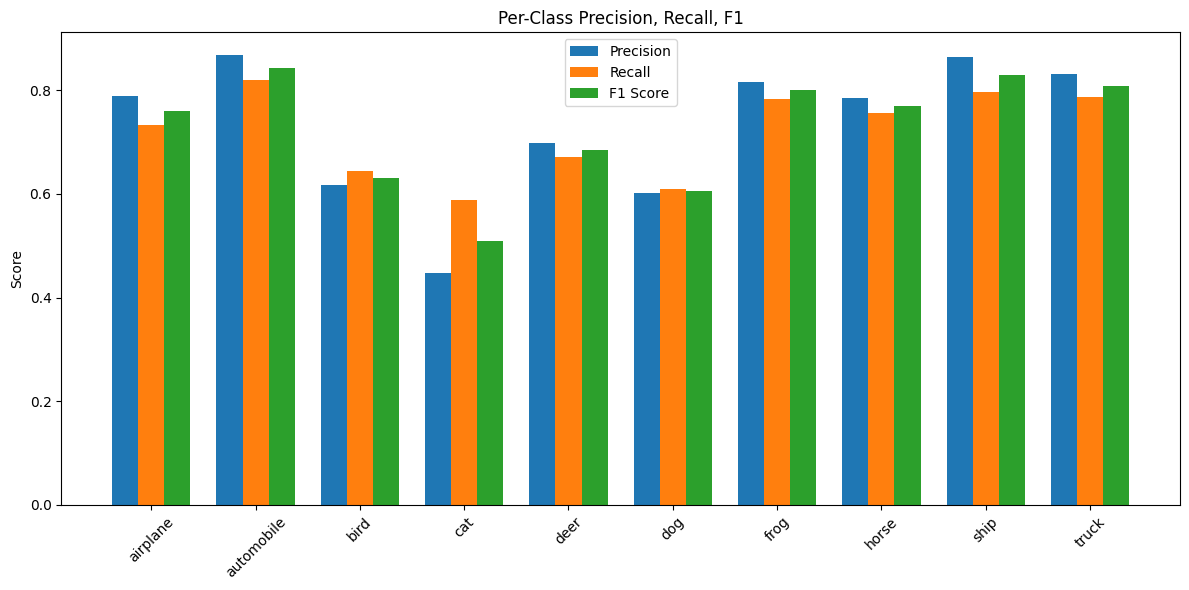

In [11]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred)

x = np.arange(len(cifar10_labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')
plt.xticks(x, cifar10_labels, rotation=45)
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, F1")
plt.legend()
plt.tight_layout()
plt.savefig("per_class_barplot.png")
plt.show()

# Training for K=4000

Doing the training on all the dataset was taking very long time for one epoch (according to 5 epoch completion, I calculated that it needs to run for 12.5 hours, so I am sampling only a part of the dataset for training)

In [10]:
X = X_train_std
y = y_train
num_per_class = 3500
num_classes = len(np.unique(y))
subset_indices = []

np.random.seed(888) 

for c in range(num_classes):
    class_idx = np.where(y == c)[0]
    selected = np.random.choice(class_idx, num_per_class, replace=False)
    subset_indices.extend(selected)

subset_indices = np.array(subset_indices)
np.random.shuffle(subset_indices)

X_small = X[subset_indices]
y_small = y[subset_indices]

print(f"Subsampled: {X_small.shape}, with {num_per_class} samples per class")

Subsampled: (35000, 36000), with 3500 samples per class


In [11]:
alpha = 1 / (400 * len(X_small)) 

clf = SGDClassifier(
    loss="hinge", 
    penalty="l2", 
    alpha=alpha,
    max_iter=1000,
    tol=1e-3,
    random_state=888,
    verbose=1,
    n_jobs=-1
)

clf.fit(X_small, y_small)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 283127.56, NNZs: 36000, Bias: -546653.175761, T: 35000, Avg. loss: 224622.152596Norm: 278673.12, NNZs: 36000, Bias: -527888.477145, T: 35000, Avg. loss: 241923.152296
Total training time: 37.64 seconds.
-- Epoch 2
Norm: 265374.84, NNZs: 36000, Bias: -553458.944776, T: 35000, Avg. loss: 226700.470661
Total training time: 37.71 seconds.
-- Epoch 2

Total training time: 37.74 seconds.
-- Epoch 2
Norm: 271167.34, NNZs: 36000, Bias: -557914.619709, T: 35000, Avg. loss: 231417.494432
Total training time: 37.76 seconds.
-- Epoch 2
Norm: 272315.59, NNZs: 36000, Bias: -556910.368772, T: 35000, Avg. loss: 253710.099811
Total training time: 37.77 seconds.
-- Epoch 2
Norm: 275656.00, NNZs: 36000, Bias: -549082.549641, T: 35000, Avg. loss: 262446.054478
Total training time: 37.78 seconds.
-- Epoch 2
Norm: 260965.94, NNZs: 36000, Bias: -564829.946256, T: 35000, Avg. loss: 267189.424196
Total training time: 

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 90.2min remaining: 60.1min


Norm: 276015.88, NNZs: 36000, Bias: -832979.475046, T: 1435000, Avg. loss: 1845.503533
Total training time: 1531.13 seconds.
-- Epoch 42
Norm: 230649.64, NNZs: 36000, Bias: -858708.106854, T: 2485000, Avg. loss: 775.883818
Total training time: 2476.89 seconds.
-- Epoch 72
Norm: 284243.09, NNZs: 36000, Bias: -644476.542678, T: 5915000, Avg. loss: 1265.637526
Total training time: 5440.04 seconds.
-- Epoch 170
Norm: 270007.84, NNZs: 36000, Bias: -686553.236887, T: 5915000, Avg. loss: 1478.115734
Total training time: 5441.65 seconds.
-- Epoch 170
Norm: 274628.00, NNZs: 36000, Bias: -831798.239252, T: 1470000, Avg. loss: 1748.728776
Total training time: 1577.90 seconds.
-- Epoch 43
Norm: 229728.17, NNZs: 36000, Bias: -858287.700022, T: 2520000, Avg. loss: 711.490247
Total training time: 2523.70 seconds.
-- Epoch 73
Norm: 284009.31, NNZs: 36000, Bias: -643769.856433, T: 5950000, Avg. loss: 1259.872479
Total training time: 5487.40 seconds.
-- Epoch 171
Norm: 269635.03, NNZs: 36000, Bias: -685

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 113.1min finished


SGDClassifier(alpha=7.142857142857142e-08, n_jobs=-1, random_state=888,
              verbose=1)

# Run the code block below to get the all the necessary data and the trained model

In [12]:
X_train = np.load("K_4000/X_train.npy")
X_test = np.load("K_4000/X_test.npy")
y_train = np.load("K_4000/y_train.npy")
y_test = np.load("K_4000/y_test.npy")
patches = np.load("K_4000/patches.npy")
pca_model = joblib.load("K_4000/pca_model.pkl")
whitened_patches = np.load("K_4000/whitened_patches.npy")
centroids = np.load("K_4000/centroids.npy")
scaler = joblib.load("K_4000/scaler.pkl")
X_test_std = np.load("K_4000/X_test_std.npy")
X_train_std = np.load("K_4000/X_train_std.npy")
clf = joblib.load("K_4000/sgd_svm_model_3500img_iter.pkl")

In [13]:
y_pred = clf.predict(X_test_std)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (K=4000, 3.5k train samples per class): {acc * 100:.2f}%")

Test Accuracy (K=4000, 3.5k train samples per class): 72.99%


In [14]:
true_epochs = clf.t_ / X_train_std.shape[0]
print(f"True number of epochs run: {true_epochs:.2f}")

True number of epochs run: 130.90


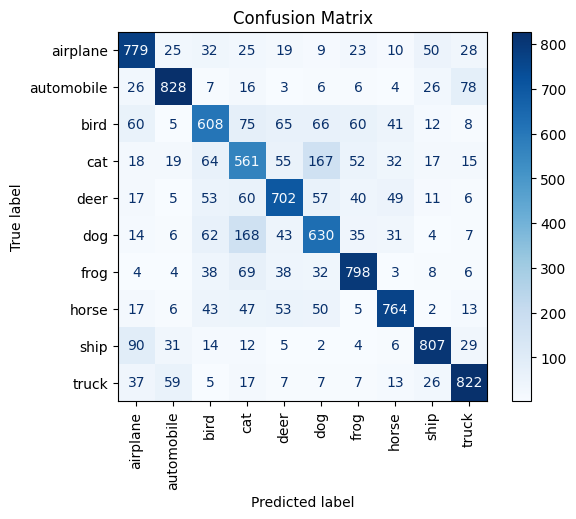

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=cifar10_labels,
    cmap="Blues",
    xticks_rotation=90
)
plt.title("Confusion Matrix")
plt.show()

In [16]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

Classification Report:
              precision    recall  f1-score   support

           0      0.734     0.779     0.756      1000
           1      0.838     0.828     0.833      1000
           2      0.657     0.608     0.631      1000
           3      0.534     0.561     0.547      1000
           4      0.709     0.702     0.706      1000
           5      0.614     0.630     0.622      1000
           6      0.775     0.798     0.786      1000
           7      0.802     0.764     0.782      1000
           8      0.838     0.807     0.822      1000
           9      0.812     0.822     0.817      1000

    accuracy                          0.730     10000
   macro avg      0.731     0.730     0.730     10000
weighted avg      0.731     0.730     0.730     10000



In [17]:
classes = np.unique(y_test)
per_class_acc = [(y_test[y_test == cls] == y_pred[y_test == cls]).mean() for cls in classes]

for label, acc in zip(cifar10_labels, per_class_acc):
    print(f"{label:10}: Accuracy = {acc * 100:.2f}%")

print("\nSorted descending per-class accuracy:")
label_acc_pairs = list(zip(cifar10_labels, per_class_acc))
sorted_pairs = sorted(label_acc_pairs, key=lambda x: x[1], reverse=True)
for label, acc in sorted_pairs:
    print(f"{label:10}: Accuracy = {acc * 100:.2f}%")

airplane  : Accuracy = 77.90%
automobile: Accuracy = 82.80%
bird      : Accuracy = 60.80%
cat       : Accuracy = 56.10%
deer      : Accuracy = 70.20%
dog       : Accuracy = 63.00%
frog      : Accuracy = 79.80%
horse     : Accuracy = 76.40%
ship      : Accuracy = 80.70%
truck     : Accuracy = 82.20%

Sorted descending per-class accuracy:
automobile: Accuracy = 82.80%
truck     : Accuracy = 82.20%
ship      : Accuracy = 80.70%
frog      : Accuracy = 79.80%
airplane  : Accuracy = 77.90%
horse     : Accuracy = 76.40%
deer      : Accuracy = 70.20%
dog       : Accuracy = 63.00%
bird      : Accuracy = 60.80%
cat       : Accuracy = 56.10%


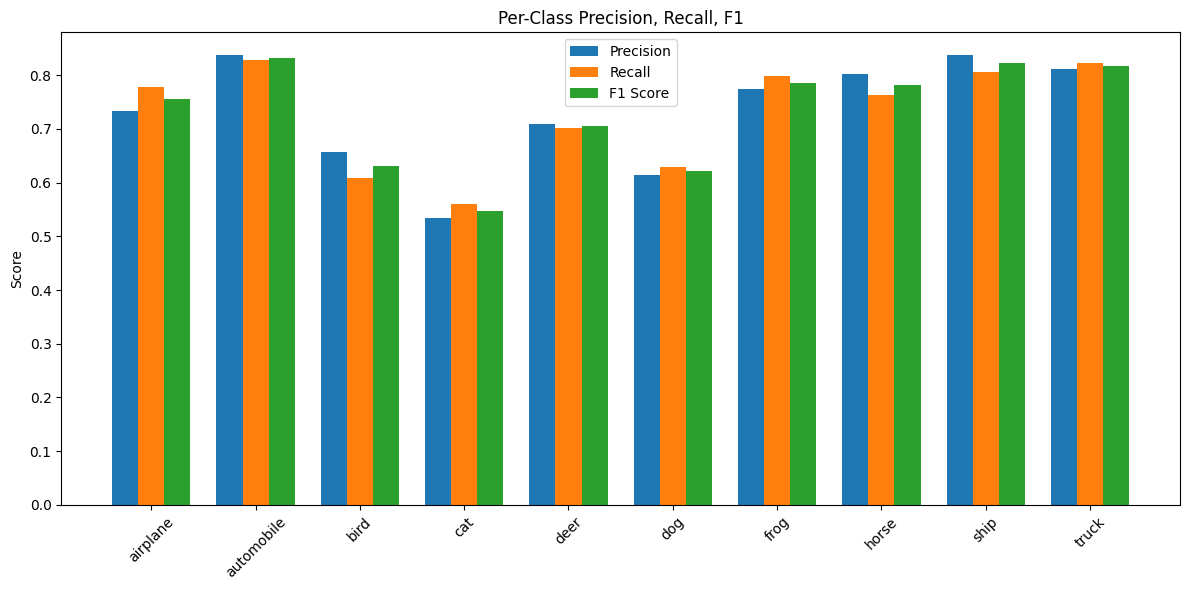

In [18]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred)

x = np.arange(len(cifar10_labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')
plt.xticks(x, cifar10_labels, rotation=45)
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, F1")
plt.legend()
plt.tight_layout()
plt.savefig("per_class_barplot.png")
plt.show()